Notebook version 1.0, 31 Aug 2021. Written by Joona Andersson / CSC - IT Center for Science Ltd. joona.andersson77@gmail.com

Licensed under the MIT license: http://www.opensource.org/licenses/mit-license.php
***
# Applying Noise to QAOA
This notebook explains how to apply noise to QAOA for the MaxCut algorithm. It shows how to extract the circuit from the MaxCut problem class and how to measure the expectation value of an observable on a noisy QPU. We are going to use the Clifford gate set $(H, S, RX, RY, RZ, CNOT)$ with the addition of the $PH$ gate so that no circuit conversion is needed. The phase gate (PH) can be implemented in practice using the other Clifford $+ T$ gates but that is omitted here.

In [ ]:
## defining the networkx Graph
import networkx as nx
nodes = 6
graph = nx.generators.random_graphs.erdos_renyi_graph(n=nodes, p=0.5) 
nx.draw(graph,with_labels=True) # vizualization of the randomly generated graph

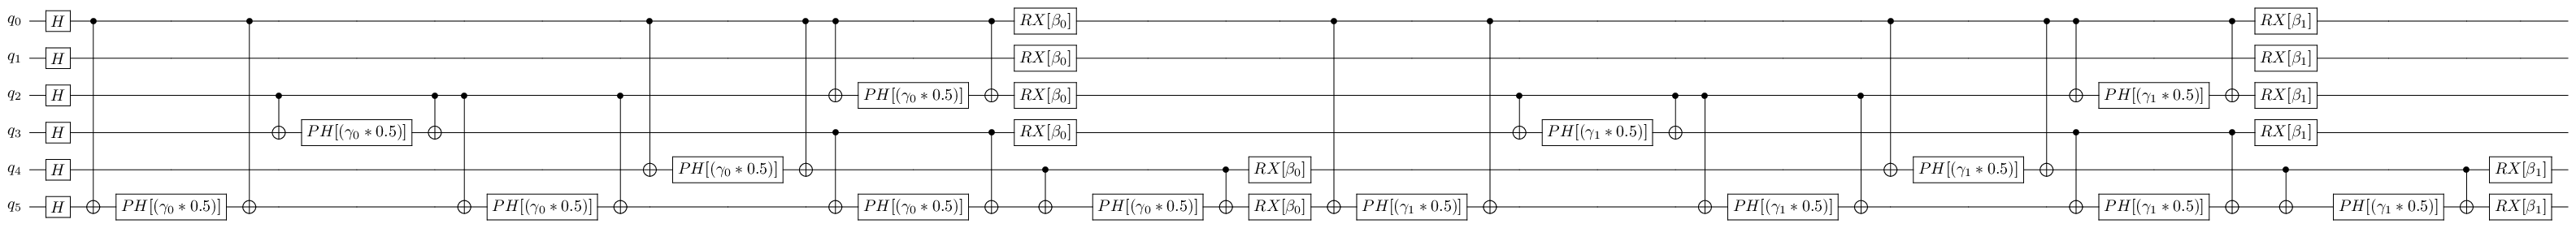

{'size': 60, 'gates': {'custom gate': 0, 'H': 6, 'CNOT': 28, 'PH': 14, 'RX': 12}, 'measure': 0, 'reset': 0, 'logic': 0, 'break': 0, 'remap': 0, 'gate_size': 60}


In [2]:
## defining the Max-Cut problem
from qat.vsolve.qaoa import MaxCut
problem = MaxCut(graph) # Instatiate MaxCut problem, with the above graph as an input

H = problem.get_observable() # Get the problem Hamiltonian

p = 2 # Depth of QAOA

ansatz = problem.qaoa_ansatz(depth = p) # creates ansatz with one pair of 'QAOA blocks' applied

 # extract a corresponding circuit object from the ansatz
circuit = ansatz.circuit

%qatdisplay circuit
## In case the circuit is too big to draw, we can use qat.core.util.statistics to
# see how the circuit is built.
from qat.core.util import statistics
print(statistics(circuit))

### Noisy Simulation of the Algorithm
Now that we know what gates our QAOA circuit uses, we can define noise models for this circuit the same way as with any other circuit. We need to define noisy Hadamards (H), phase gates (PH), X-rotations (RX), and CNOT gates. In addition, we define amplitude damping and pure dephasing noise to model environmental noise. This noise affects qubits during the whole duration of the algorithm. Learn more here: https://arxiv.org/abs/1904.06560

In [3]:
## Specifications for gate fidelities and gate times. Change these
# values to observe how the they affect the results of the algorithm

# X rotation gate
Xrot_fidelity = 0.995 # probability of success
Xrot_time = 30 # gate duration in nanoseconds

# H gate
H_fidelity = 0.99
H_time = 30

# CNOT gate
CNOT_fidelity = 0.98
CNOT_time = 280 

# PH gate
PH_fidelity = 0.99
PH_time = 30

## Environmetal noise parameters
T1 = 120000 # qubit's energy relaxation time in nanoseconds
T2 = 190000 # qubit's dephasing time in nanoseconds

Here we define quantum channels for the gates we use in the circuit. In order to do this, one needs to know how to represent gates in their matrix form. These can be found under "The AQASM format" section in the QLM documentation, for example.

In [5]:
from qat.quops import QuantumChannelKraus ## Kraus representation of quantum channels
import numpy as np # numpy is used to generate matrices

# Noisy X-rotation
px = Xrot_fidelity # probability that the RX(theta) rotation succeeds
noisy_RX = lambda theta : QuantumChannelKraus([np.sqrt(px)*np.array([[np.cos(theta/2), -np.sin(theta/2)*1j],
                                                     [-np.sin(theta/2)*1j, np.cos(theta/2)]]), # the RX(pi/2) gate -> gate succeeds
                                       np.sqrt(1-px)*np.identity(2)],   # the identity -> nothing happens
                                       name="noisy RX(pi/2)")           # name of the quantum operation/channel

# Noisy Hadamard
ph = H_fidelity
noisy_H = QuantumChannelKraus([np.sqrt(ph)*np.array([[1, 1],
                                                      [1, -1]]/np.sqrt(2)),
                                      np.sqrt(1-ph)*np.identity(2)],   
                                       name="noisy H")          

# Noisy CNOT
pcnot = CNOT_fidelity # probability that the CNOT rotation succeeds
noisy_CNOT = QuantumChannelKraus([np.sqrt(pcnot)*np.array([[1, 0, 0, 0],
                                                           [0, 1, 0, 0],
                                                           [0, 0, 0, 1],
                                                           [0, 0, 1, 0]]),         # the CNOT gate -> gate succeeds   
                                                  np.sqrt(1-pcnot)*np.identity(4)],# the identity -> nothing happens
                                                   name="noisy CNOT")
# Noisy PH
pph = PH_fidelity
noisy_PH = lambda theta : QuantumChannelKraus([np.sqrt(pph)*np.array([[1,0],
                                                                      [0, np.exp(theta*1j)]]),
                                              np.sqrt(1-pph)*np.identity(2)], name="noisy PH")


In [6]:
from qat.quops import ParametricPureDephasing, ParametricAmplitudeDamping
## Amplitude Damping characterized by T_1
amp_damp = ParametricAmplitudeDamping(T_1 = T1)

## Pure Dephasing characterized by T_phi. The contribution of amplitude damping (T1) is removed 
## from transverse relaxation (T2) to give pure dephasing only (T_phi)
pure_deph = ParametricPureDephasing(T_phi = 1/(1/T2 - 1/(2*T1))) 

from itertools import product

## Amplitude damping channel for two qubits. We build a new 4x4 quantun channel whose Kraus operators
## are pairwise Kronecker products of the Kraus operators of single qubit amplitude damping channels.
## The gate duration of CNOT is given as parameter 'tau' to amp_damp.  
two_qbit_amp_damp = QuantumChannelKraus([np.kron(k1, k2) 
                                     for k1, k2 in product(amp_damp(tau=CNOT_time).kraus_operators,
                                                           amp_damp(tau=CNOT_time).kraus_operators)])

## Pure dephasing channel for two qubits. The logic is exactly same as above.
two_qbit_pure_deph = QuantumChannelKraus([np.kron(k1, k2)
                                     for k1, k2 in product(pure_deph(tau=CNOT_time).kraus_operators,
                                                           pure_deph(tau=CNOT_time).kraus_operators)])

/usr/lib64/python3.6/site-packages/qat/core/magic/magic.py:157: UserWarning: FixedFormatter should only be used together with FixedLocator
  time_plot_advanced(circuit, hardware_model, filename)


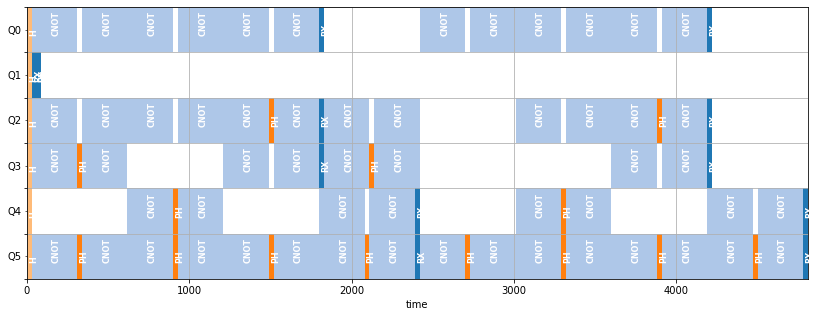

In [7]:
## Let's define environmental noise during gates. 
## The series concatenation of quantum channels is implemented in pyAQASM by the '*' operator.
## We set amplitude damping and pure dephasing channels to follow all gate operations 
## (this is approximating environmental noise during these gates).
gates_noise = {"RX" : lambda _: amp_damp(tau=Xrot_time)*pure_deph(tau=Xrot_time),  
               "H" : lambda : amp_damp(tau=H_time)*pure_deph(tau=H_time),
               "CNOT" : lambda : two_qbit_amp_damp*two_qbit_pure_deph,
               "PH" : lambda _: amp_damp(tau=PH_time)*pure_deph(tau=PH_time)}

# This dictionary connects the noisy quantum channels to gate names
quantum_channels = {"RX": noisy_RX,"H": noisy_H, "CNOT": noisy_CNOT, 'PH': noisy_PH}

## Dictionary connecting the gate durations to the gate's name
gate_times = {"H": H_time,"RX": Xrot_time, "CNOT": CNOT_time, 'PH': PH_time} 

from qat.hardware import GatesSpecification
## instanciate a GatesSpecification with gate times and the corresponding quantum channels
gates_spec = GatesSpecification(gate_times, quantum_channels)

from qat.hardware.default import HardwareModel
hw_model = HardwareModel(gates_spec, gate_noise=gates_noise, idle_noise=[amp_damp, pure_deph])

## Display the circuit as a timeline of quantum operations where colored boxes represent noisy quantum gates
## and white boxes noisy idling periods.
%qatdisplay circuit --hardware hw_model

### Optimizing Circuit parameters

In [8]:
from qat.plugins import ScipyMinimizePlugin # import the plugin for optimization

## Instantiate the classical optimizer using Constrained Optimization BY Linear Approximation (COBYLA) method
optimizer = ScipyMinimizePlugin(method="COBYLA",     # the optimization method
                            tol=1e-2,                # tolerance is a threshold which, if crossed,
                                                     # stops the iterations of an optimizer
                            options={"maxiter":150}) # maximum optimization iterations. 
                                                     # Needs to be large enough for result to converge
                                                     # (see below) 

Noisy simulations require another plugin called ObservableSplitter to be added to the stack before the optimization step. This is because calculating the expectation value of a given observable is not implemented for NoisyQProc which we use for noisy simulations.

In [ ]:
from qat.plugins import ObservableSplitter
from qat.qpus import NoisyQProc

## Now we can stack the classical optimizer, ObservableSplitter and NoisyQProc
stack = optimizer | ObservableSplitter() | NoisyQProc(hw_model)

 ## now the job is set to calculate the expectation value for H.
job = circuit.to_job('OBS', observable=H, nbshots=0)

noisy_result = stack.submit(job)
print('Optimized noisy value: ', noisy_result.value)  

Let's perform the same measurement on an ideal circuit to confirm that our noise definitions had an effect on the energy measurement of the observable. The energy reading given by the ideal circuit should be lower than that of the noisy circuit.

In [ ]:
from qat.qpus import LinAlg

qpu = LinAlg()
ideal_stack = optimizer | qpu  ## NOTE: ObservableSplitter is not needed here.

job = circuit.to_job('OBS', observable=H, nbshots=0)

result = ideal_stack.submit(job)
print('Optimized ideal value', result.value)

## Retrieving the maximum cut
The goal in MaxCut is to partition the vertices (modelled as qubits) to two subgraphs such that the disagreement between neighbors is maximized which is equivalent to maximizing the number of cut edges. By measuring  $|\gamma_{optimal},\beta_{optimal}>$ in the computational basis, we can divide the qubits into the two different subgraphs. This is because qubits belonging to different subgraphs will have different measurement results.

In [ ]:
## Fetch the parameters
params = eval(noisy_result.meta_data['parameters']) # the optimal parameters are in the metadata of the result
gammas = params[0:p] # gammas are the first p values of the parameter array, where p is the depth of the ansatz
betas = params[p:] # betas are the last p values of the parameter array, where p is the depth of the ansatz

# Bind the parameters into the QAOA circuit
circuit_optimal = circuit.bind_variables({key : var for key, var in zip(circuit.get_variables(),params)})

%qatdisplay circuit_optimal

job2 = circuit_optimal.to_job(nbshots=0)
result2 = NoisyQProc(hw_model).submit(job2) 

print("Samples from measurements of the state with optimal parameters:")
for sample in result2:
    if sample.probability > 0.01: # only consider samples with reasonable probability
        print(sample.state.value[0],", probability:", sample.probability)

## To plot the optimal graph partition, let's find the optimal solution that occurs with highest probability 
solutions = {} # initialize a Python dictionary

## loop over samples to collect the measurement outcomes and their probabilities to the dictionary
for sample in result2:                                                    
        solutions.update({sample.state.value[0] : sample.probability})    
        
most_probable_solution = max(solutions, key=solutions.get) # find the key i.e. state that has maximum probability
print("-------------------------------")
print("The most probable solutions is")
print(most_probable_solution)

### All states and their probabilities

In [ ]:
import matplotlib.pyplot as plt
## collect result states and their probabilities in two lists
states = [str(sample.state.value[0]) for sample in result2 if sample.probability >= 0.000]
probabilities = [sample.probability for sample in result2 if sample.probability > 0.000]

plt.figure(figsize=(12, 6))
plt.rcParams['font.size'] = 12
plt.bar(states, probabilities)
plt.xlabel('state')
plt.ylabel('probability')
plt.xticks(rotation=90)
plt.show()

### Ideal Reference:

In [ ]:
## Compare noisy results to the ideal results
ideal_result = qpu.submit(job2)

states = [str(sample.state.value[0]) for sample in ideal_result if sample.probability >= 0.000]
probabilities = [sample.probability for sample in ideal_result if sample.probability > 0.000]

plt.figure(figsize=(12, 6))
plt.rcParams['font.size'] = 12
plt.bar(states, probabilities)
plt.xlabel('state')
plt.ylabel('probability')
plt.xticks(rotation=90)
plt.show()

### Visualize the graph partition

In [ ]:
## We need to extract the indices of the 0 and 1 partitions
print("Solution configuration: \n" + str(most_probable_solution) + "\n")
indices_0 = [i for i, value in enumerate(most_probable_solution) if value == '0'] # build array holding the indices of 0's in the solution confiquration
print("The nodes in the first subgraph:\n" + str(indices_0)  + "\n")
indices_1 = [i for i, value in enumerate(most_probable_solution) if value == '1'] # build array holding the indices of 1's in the solution confiquration
print("The nodes in the second subgraph:\n" + str(indices_1) )

In [ ]:
## Here we visualize the solution of the MaxCut problem. 
import matplotlib.pyplot as plt
nodes_positions = nx.spring_layout(graph)
plt.figure(figsize=(12,8)) 
node_size = 440
font_size = 14
nx.draw_networkx(graph,                # the nodes of '0'-partition will be colored blue  
                 pos=nodes_positions, 
                 nodelist=indices_0, 
                 node_color='steelblue', 
                 node_size=node_size, 
                 font_size=font_size)

nx.draw_networkx(graph,                # the nodes of '1'-partition will be colored red
                 pos=nodes_positions, 
                 nodelist=indices_1, 
                 node_color='red', 
                 node_size=node_size, 
                 font_size=font_size)
 
plt.show()